## Chains using LangGraph
- How to use chat messages as our graph nodes
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes

In [1]:
from dotenv import load_dotenv
import os
load_dotenv()

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')

#### Messages
We can use messages which can be used to capture different roles within a conversation. LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage. These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have three important components:
- content: content of the message
- name: specify the name of author
- response_metadata: optionally, a dict of metadata (e.g., often populated by model provided for AIMessgae)

In [5]:
from langchain_core.messages import AIMessage, HumanMessage

messages=[AIMessage(content="Hey! how may I help you?",name='betubot')]
messages.append(HumanMessage(content="I want to check on latest updates",name='akshayhuman'))
messages.append(AIMessage(content="okay! let me provide you some",name='betubot'))
messages.append(HumanMessage(content="I want to learn python",name='akshayhuman'))

for message in messages:
    message.pretty_print()

================================== Ai Message ==================================
Name: betubot

Hey! how may I help you?
================================ Human Message =================================
Name: akshayhuman

I want to check on latest updates
================================== Ai Message ==================================
Name: betubot

okay! let me provide you some
================================ Human Message =================================
Name: akshayhuman

I want to learn python


In [37]:
from langchain_groq import ChatGroq

groq_llm=ChatGroq(model='llama-3.1-8b-instant')
result=groq_llm.invoke(messages)
print(result.content[:50])
result.response_metadata

Python is a versatile and widely used programming 


{'token_usage': {'completion_tokens': 496,
  'prompt_tokens': 77,
  'total_tokens': 573,
  'completion_time': 1.052543497,
  'prompt_time': 0.010736183,
  'queue_time': 0.627810659,
  'total_time': 1.06327968},
 'model_name': 'llama-3.1-8b-instant',
 'system_fingerprint': 'fp_c8fb515de2',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

#### Tools
- Tools can be integrated with the LLM models to interact with external systems like API's, third party tools.
- Whenever a query is asked the model can choose to call the tool and this query is based on the natural language input and this will return an output that matches the tool's schema
- How LLM will understand that whether to make a tool call or not ?
    - LLM will be binded with the tools and with the help of docString in tools, LLM will understand the tool usage
    - once the binding is done, LLM is already smart enough to understand the user query and based on that make decision to call tools or not
    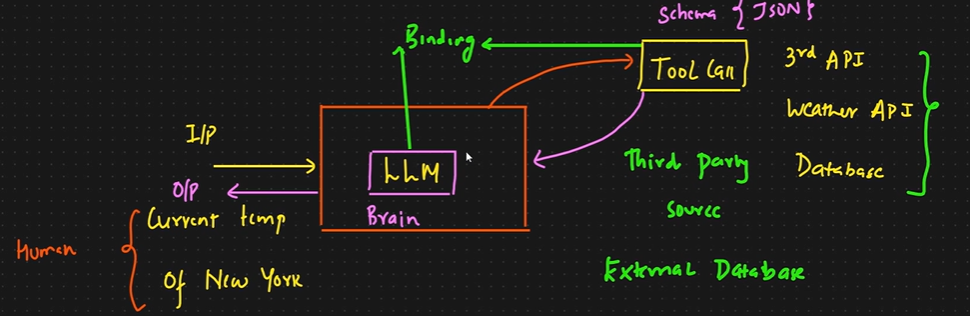

In [10]:
# tool
def add(a:int,b:int)->int:
    """ Add a and b
    Args:
        a (int): first int
        b (int): second int
    
    Returns:
        int
    """
    return a+b

In [51]:
# binding the llm with tools so that llm model will know what tools are present

groq_llm_with_tools=groq_llm.bind_tools([add])

In [40]:
groq_llm_with_tools.invoke([HumanMessage(content='2 plus 2',name='srishti')])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bsesayv55', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 255, 'total_tokens': 273, 'completion_time': 0.027138763, 'prompt_time': 0.023903964, 'queue_time': 0.051300706, 'total_time': 0.051042727}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c8fb515de2', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--4d6a04d0-29c6-4f4e-aeb3-522000a21a9c-0', tool_calls=[{'name': 'add', 'args': {'a': 2, 'b': 2}, 'id': 'bsesayv55', 'type': 'tool_call'}], usage_metadata={'input_tokens': 255, 'output_tokens': 18, 'total_tokens': 273})

as above we can see, we are not getting any response from llm instead it's made a tool_call, and below when i tired to ask which can't be answer by the present add tool, it throws and error

In [ ]:
groq_llm_with_tools.invoke([HumanMessage(content='2 minus 2',name='srishti')])

In [62]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import AnyMessage

class TypedDictState(TypedDict):
    messages: Annotated[list[AnyMessage],add_messages]

In [74]:
def llm_tool(state:TypedDictState):
    print("current state value",state['messages'])
    return {'messages':[groq_llm_with_tools.invoke(state['messages'])]}

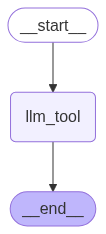

In [75]:
from langgraph.graph import StateGraph,START,END
from IPython.display import display,Image

graph=StateGraph(TypedDictState)
graph.add_node('llm_tool',llm_tool)
graph.add_edge(START,'llm_tool')
graph.add_edge('llm_tool',END)
graph_builder=graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [76]:
messages = graph_builder.invoke({"messages": '2 plus 2'})


for message in messages['messages']:
    message.pretty_print()

current state value [HumanMessage(content='2 plus 2', additional_kwargs={}, response_metadata={}, id='4ef561b6-3499-4c94-bb92-b950d9caee27')]
================================ Human Message =================================

2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (ar79ga5ds)
 Call ID: ar79ga5ds
  Args:
    a: 2
    b: 2


one point to note here is we have not got the final result from the tool_call, so to get the response will include ToolNode in the graph see below:

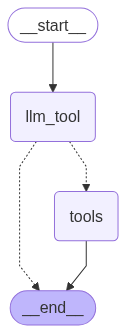

In [81]:
from langgraph.prebuilt import ToolNode, tools_condition

graph=StateGraph(TypedDictState)
graph.add_node('llm_tool',llm_tool)

# add tool node to the graph, ToolNode takes list of tool names
# IMP: node name should be "tools"
graph.add_node('tools',ToolNode([add]))

graph.add_edge(START,'llm_tool')
graph.add_edge('llm_tool',END)

# if latest result from llm is tool_call -> tools_condition routes to tools
# if latest result from llm is not tool_call -> tools_condition routes to END
graph.add_conditional_edges(
    'llm_tool',
    tools_condition
)

graph_builder=graph.compile()

display(Image(graph_builder.get_graph().draw_mermaid_png()))


In [85]:
messages=graph_builder.invoke({'messages':'what is 2 plus 2'})

for message in messages['messages']:
    message.pretty_print()

current state value [HumanMessage(content='what is 2 plus 2', additional_kwargs={}, response_metadata={}, id='009f10cb-07ce-493b-a0a9-103e0196b2d0')]
================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (yzfa1dxyy)
 Call ID: yzfa1dxyy
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [95]:
messages=graph_builder.invoke({'messages':'what is machine learning'})

for message in messages['messages']:
    message.pretty_print()

current state value [HumanMessage(content='what is machine learning', additional_kwargs={}, response_metadata={}, id='029044b7-b766-47c1-a5fb-e93194dafbf1')]
================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================

Unfortunately, I cannot provide a detailed explanation of machine learning as the available functions do not include a 'machine learning' function. However, I can provide a definition.

Machine learning is a subset of artificial intelligence that involves training algorithms to learn from data and improve their performance on a specific task over time. It is a type of programming that allows computers to learn from experience and improve their performance without being explicitly programmed.

If you want to get an in-depth explanation, it would be best to use the 'brave_search' function which is not available in the given functions.
